# (a)  A list of methods of finding the optimal portfolio
1. Markowitz
2. Single Index Model
3. Single Index Model - No Short Sale
4. Constant Correlation Model
5. Constant Correlation Model - No Short Sale
6. Multiple Group Model 
7. Equal Allocation
8. Market (SP500)

The inputs for these problems are:

 * market_return , 1D array with shape = (days,)
 * stocks_return , 2D array with shape = (days,stocks_num)
 * stocks_names , 1D array of strings with shape = (stocks_num,)
 * Rf , return of risk free asset, a floating point number
 * stocks_grouping, 1D array of int with shape = (stocks_group_num,)  
   it is only used in Multiple Group Model, for example [5,5,5,6,6],  
   

The output for problem 1 to 7 should be:  
* x , 1D array with shape = (stocks_nums,)  
x is the portflio allocation, sum(x) = one, the order is same as the stock_names

In [11]:
import pandas as pd 
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [200]:
class OP:
    # Optimal Portfolio
    # Jian Wang, Department of Physics And Astronomy, UCLA
    # June 6th, 2019
    
    def __init__( self, market_returns, stocks_returns, stocks_names, Rf, stocks_grouping):
        self.market_returns = market_returns # shape = (days,)
        self.market_return = np.mean(market_returns)
        self.market_variance = np.cov( market_returns )  # unbiased estimitor of sigma**2
        self.Rf = Rf
        self.days = len(market_returns)
        
        self.stocks_num = len(stocks_names)
        self.stocks_names = stocks_names   # shape = (stocks_num,)
        self.stocks_returns = stocks_returns # shape = (days,stocks_num)
        self.stocks_return = np.mean( stocks_returns , axis = 0 )        # shape = (stocks_num,)
        self.stocks_covariance = np.cov( np.transpose(stocks_returns) )  # shape = (stocks_num,stocks_num)

        self.stocks_grouping = stocks_grouping
        self.stocks_group_num = len(stocks_grouping)
    
        return None
    
    # Markowitz
    def x1(self):
        z = np.matmul( inv( self.stocks_covariance ), self.stocks_return - self.Rf )
        x = z/np.sum(z)
        return x
    
    # Single Index Model 
    def _alpha_beta_sigma2( self, i ):
        # self.stocks_returns[:,i]  is the days series of stock #i's return
        a = np.sum( ( self.stocks_returns[:,i] - self.stocks_return[i] ) \
                    *( self.market_returns - self.market_return )   )
        b = np.sum( ( self.market_returns - self.market_return )**2 )
        beta = a/b
        alpha = self.stocks_return[i] - beta * self.market_return
        c = np.sum( ( self.stocks_returns[:,i] - alpha - beta * self.market_returns )**2 )
        stock_residue_sigma_square = c / ( self.days - 2 )
        return alpha, beta, stock_residue_sigma_square
    
    def _alpha_beta_sigma2s( self ):
        temp = []
        for i in range( self.stocks_num ):
            temp.append(  self._alpha_beta_sigma2(i) )
        SIM_parameters = np.array(temp)
        return SIM_parameters
        # shape = (self.stocks_num,3)
        # [[alpha, beta, stock_residue_sigma_square] * stocks_num ] 

    def x2_stocks_covariance( self ):
        SIM_parameters = self._alpha_beta_sigma2s()
        betas = SIM_parameters[:,1]
        stock_residue_sigma_square = SIM_parameters[:,2]
        n = self.stocks_num
        stocks_covariance = np.matmul(  betas.reshape(n,1), betas.reshape(1,n) ) * self.market_variance
        stocks_covariance = stocks_covariance + np.diag( stock_residue_sigma_square )
        return stocks_covariance
        # shape = ( stocks_num , stocks_num )

    def x2(self):
        z = np.matmul( inv( self.x2_stocks_covariance() ), self.stocks_return - self.Rf )
        x = z/np.sum(z)
        return x
    
    def x3_table( self ):

        # (1) generate the first part of the table 
        SIM_parameters = self._alpha_beta_sigma2s()
        dat0 = pd.DataFrame({"stocks_names":self.stocks_names})
        dat1 = pd.DataFrame({"alpha": SIM_parameters[:,0]})
        dat2 = pd.DataFrame({"beta": SIM_parameters[:,1]})
        dat3 = pd.DataFrame({"stock_residue_sigma_square": SIM_parameters[:,2] })
        dat4 = pd.DataFrame({"(Ri-Rf)/beta": (self.stocks_return - self.Rf)/SIM_parameters[:,1] })

        dat5 =  pd.DataFrame({"(Ri-Rf)*beta/residueSigmaSquare": \
                              (self.stocks_return - self.Rf)*SIM_parameters[:,1]/SIM_parameters[:,2] })
        dat6 =  pd.DataFrame({"betaSquare/residueSigmaSquare" : \
                              SIM_parameters[:,1]**2/SIM_parameters[:,2] })
        dat = dat0.join(dat1).join(dat2).join(dat3).join(dat4).join(dat5).join(dat6)

        # (2) delete negative beta and sort (excess-return)/beta ratio from largest to smallest
        for index, row in dat.iterrows():
            if row['beta'] < 0:
                dat.drop(index, inplace=True)
        dat.sort_values(by=["(Ri-Rf)/beta"] , ascending=False ,inplace = True)
        dat.reset_index( drop=True ,inplace = True )

        # (3) compute the remining part of the table
        COL2 , COL4 , Cstar = [] , [] , []
        temp2 ,temp4 , tempCstart = 0 , 0 , 0
        for i in range(len(dat.index)):
            temp2 = temp2 + dat.iloc[i]["(Ri-Rf)*beta/residueSigmaSquare"]
            temp4 = temp4 + dat.iloc[i]["betaSquare/residueSigmaSquare"]
            tempCstar = temp2 * self.market_variance /( temp4 * self.market_variance + 1)
            COL2.append(temp2)
            COL4.append(temp4)
            Cstar.append(tempCstar)
        dat7 =  pd.DataFrame({"COL2" : COL2 })
        dat8 =  pd.DataFrame({"COL4" : COL4 })
        dat9 =  pd.DataFrame({"Cstar" : Cstar })
        dat = dat.join(dat7).join(dat8).join(dat9)

        return dat
    
    def x3(self):
        table = self.x3_table()
        # (1) find the Cstar
        ntable = len( table["Cstar"] )
        n_buy_stock = 0 
        for i in range( ntable ):
            if table["(Ri-Rf)/beta"][i] <  table["Cstar"][i]:
                break
            Cstar = table["Cstar"][i]
            n_buy_stock = n_buy_stock + 1

        z = (table["(Ri-Rf)/beta"][:n_buy_stock] - Cstar)\
            *table["beta"][:n_buy_stock]/table["stock_residue_sigma_square"][:n_buy_stock]
        x = z / np.sum(z)

        n = self.stocks_num
        x_original_ordered = [ 0 ] * n 
        for i in range( n_buy_stock ):
            name = table["stocks_names"][i]
            value = x[i]
            j = 0
            for s in stock_names:
                if name == s:
                    x_original_ordered[j] = value
                j = j + 1
        return np.array( x_original_ordered )


    
    
    # Constant Correlation Model
    def _constant_rho( self ):
        out = 0 
        n = self.stocks_num
        for i in range(n):
            for j in range(n):
                if i != j :
                    temp = self.stocks_covariance[i,j]/ \
                    np.sqrt( self.stocks_covariance[i,i] * self.stocks_covariance[j,j] )
                    out = out + temp
        out = out / n / (n-1)
        return out
    
    def x4_stocks_covariance( self ):
        rho = self._constant_rho()
        n = self.stocks_num
        out = self.stocks_covariance.copy()
        for i in range(n):
            for j in range(n):
                if i != j:
                    out[i,j] = rho * np.sqrt( self.stocks_covariance[i,i] * self.stocks_covariance[j,j] )
        return out
        # shape = ( stocks_num , stocks_num )
    
    def x4(self):
        z = np.matmul( inv( self.x4_stocks_covariance() ), self.stocks_return - self.Rf )
        x = z/np.sum(z)
        return x
    
    def x5_table( self ):

        # (1) generate the first part of the table 
        dat0 = pd.DataFrame({"stocks_names":self.stocks_names})
        dat1 = pd.DataFrame({"stocks_return": self.stocks_return })
        dat2_ = self.stocks_return - self.Rf
        dat2 = pd.DataFrame({"excess_return": dat2_  })
        dat3_ = np.sqrt(np.diag(self.stocks_covariance))
        dat3 = pd.DataFrame({"sigma":  dat3_  })
        dat4_ = dat2_/ dat3_
        dat4 = pd.DataFrame({"(Ri-Rf)/sigma": dat4_ })
        dat = dat0.join(dat1).join(dat2).join(dat3).join(dat4)
        dat.sort_values(by=["(Ri-Rf)/sigma"] , ascending=False ,inplace = True)
        dat.reset_index( drop=True ,inplace = True )
        n = self.stocks_num
        rho = self._constant_rho()
        dat5_ = rho/ ( 1 + rho * ( np.array([i for i in range(1,n+1)]) -1 )  )
        dat5 =  pd.DataFrame({"rho/(1-rho+i*rho)": dat5_ })
        temp = 0 
        dat6_ = np.array( [ np.sum( dat.iloc[:i]["(Ri-Rf)/sigma"] ) for i in range(1,n+1) ] )
        dat6 =  pd.DataFrame({"sum[(Ri-Rf)/sigma]" : dat6_ })
        dat7_ = np.array( [ i[0]*i[1] for i in zip(dat5_,dat6_)])
        dat7 =  pd.DataFrame({"Ci" : dat7_ })
        dat = dat.join(dat5).join(dat6).join(dat7)
        return dat
    
    def x5(self):
        table = self.x5_table()
        ntable = len( table["Ci"] )
        n_buy_stock = 0 
        for i in range( ntable ):
            if table["(Ri-Rf)/sigma"][i] <  table["Ci"][i]:
                break
            Cstar = table["Ci"][i]
            n_buy_stock = n_buy_stock + 1

        z = (table["(Ri-Rf)/sigma"][:n_buy_stock] - Cstar) /table["sigma"][:n_buy_stock]
        x = z / np.sum(z)
        n = self.stocks_num
        x_original_ordered = [ 0 ] * n 

        for i in range( n_buy_stock ):
            name = table["stocks_names"][i]
            value = x[i]
            j = 0
            for s in self.stocks_names:
                if name == s:
                    x_original_ordered[j] = value
                j = j + 1

        return np.array( x_original_ordered )
    
    
    # Multiple Group Model 
    def x6_stocks_covariance( self ):
        n = self.stocks_num
        grouping = self.stocks_grouping
        rho = [ [0]*n for _ in range(n) ]
        for i in range(n):
            for j in range(n):
                if i != j :
                    rho[i][j] = self.stocks_covariance[i,j]/ \
                    np.sqrt( self.stocks_covariance[i,i] * self.stocks_covariance[j,j] )
                else:
                    rho[i][j] = 0
        rho = np.array(rho)
        isum = 0 
        for i in grouping:
            jsum = 0
            for j in grouping:
                if isum != jsum:
                    temp =  rho[isum:isum+i,jsum:jsum+j].mean() 
                    rho[isum:isum+i,jsum:jsum+j] = temp
                else:
                    temp = rho[isum:isum+i,jsum:jsum+j].sum() / (i*i - i)
                    rho[isum:isum+i,jsum:jsum+j] = temp
                jsum = jsum + j
            isum = isum + i
        new_covariance = [ [0]*n for _ in range(n) ]
        for i in range(n):
            for j in range(n):
                if i != j :
                    new_covariance[i][j] = rho[i,j] * \
                    np.sqrt( self.stocks_covariance[i,i] * self.stocks_covariance[j,j] )
                else:
                    new_covariance[i][j] = self.stocks_covariance[i,j]
        new_covariance = np.array(new_covariance)
        return new_covariance

    def x6(self):
        z = np.matmul( inv( self.x6_stocks_covariance() ), self.stocks_return - self.Rf )
        x = z/np.sum(z)
        return x
    
    # Equal Allocation Model
    def x7(self):
        x = np.array( [1/self.stocks_num]*self.stocks_num )
        return x
    
    
    
    def Sharpe_ratio(self, x ):
        sigma2 = np.matmul( np.matmul( x, self.stocks_covariance ) , x )
        retur = np.sum( self.stocks_return * x )
        return (retur - self.Rf)/ np.sqrt(sigma2)
    
    def Treynor_measure(self , x):
        betas = self._alpha_beta_sigma2s()[:,1]
        beta = np.sum( betas * x )
        retur = np.sum( self.stocks_return * x )

        return (retur - self.Rf)/beta
    
    def Jensen_differential_performance_index(self, x):
        betas = self._alpha_beta_sigma2s()[:,1]
        beta = np.sum( betas * x )
        retur = np.sum( self.stocks_return * x )
        return (retur - self.Rf) - beta * (self.market_return - self.Rf)
        

## Read from csv table, convert to numpy array as input
## Create the OP class

In [201]:
a=pd.read_csv("stockData_proj_1.csv")
# the first selected stock must be market
market_name  = a.columns.tolist()[2 ]
stocks_names  = a.columns.tolist()[3:]

market_prices = a[market_name].values
stocks_prices = a[stock_names].values

market_returns = (market_prices[1:]-market_prices[0:-1])/market_prices[1:]
stocks_returns = (stocks_prices[1:,:]-stocks_prices[0:-1,:])/stocks_prices[1:,:]
print(market_returns.shape, stocks_returns.shape)


Rf = 0.002
stocks_grouping = [5,5,5,6,6]

b = OP( market_returns, stocks_returns, stocks_names, Rf, stocks_grouping)

(98,) (98, 27)


### plot the portfolio for different methods

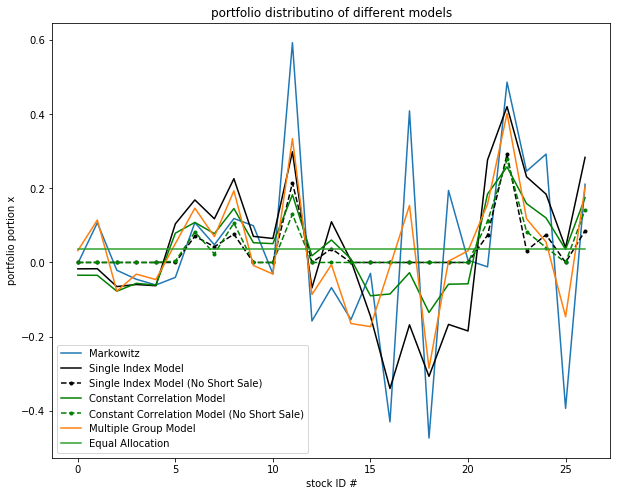

In [186]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(b.x1())
plt.plot(b.x2(),color="black")
plt.plot(b.x3(), '--.',color="black")
plt.plot(b.x4()  ,color = "g")
plt.plot(b.x5(), '--.' ,color = "g")

plt.plot(b.x6())
plt.plot(b.x7())

plt.legend(["Markowitz","Single Index Model","Single Index Model (No Short Sale)",\
            "Constant Correlation Model",\
            "Constant Correlation Model (No Short Sale)","Multiple Group Model",\
            "Equal Allocation"])

plt.xlabel("stock ID #")
plt.ylabel("portfolio portion x")
plt.title("portfolio distributino of different models")
plt.show()

## Plot their performace
### Notice that AMAZON stock has x10 times growth over the past 8 years
### When short sale is allowed, leverage effect makes the portfolio performs even better x30 times return

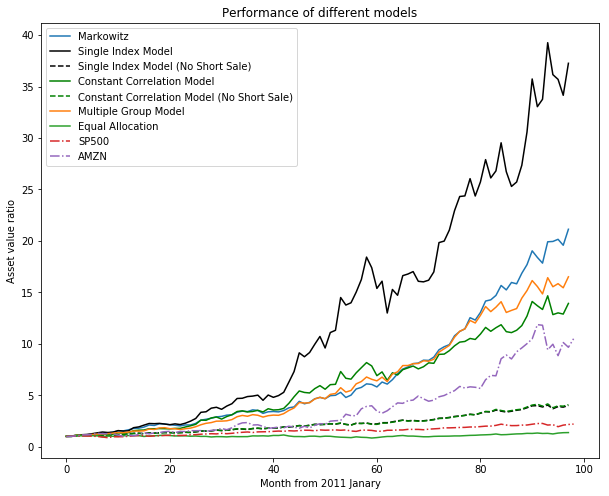

In [188]:

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x1() )  ) )
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x2() )  ), color="black")
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x3() )  ) , '--',color="black")
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x4() )  ) , color="g")
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x5() )  ) , '--' , color="g")

plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x6() )  ) )
plt.plot(np.cumprod( 1 + np.matmul( b.stocks_returns , b.x7() )  ) )

plt.plot( market_prices/market_prices[0], '-.')
plt.plot( a["AMZN"]/a["AMZN"][0], '-.')

plt.legend(["Markowitz","Single Index Model","Single Index Model (No Short Sale)",\
            "Constant Correlation Model",\
            "Constant Correlation Model (No Short Sale)","Multiple Group Model",\
            "Equal Allocation","SP500" , "AMZN"])
plt.xlabel("Month from 2011 Janary")
plt.ylabel("Asset value ratio")
plt.title("Performance of different models")
plt.show()

In [190]:
def plot_stocks( b ):
        
    # (1) plot the (risk,return) for all the stocks
    xp = np.sqrt( np.diag( b.stocks_covariance) )
    yp = b.stocks_return
    stocknamelist = b.stocks_names
    plt.plot( xp , yp ,'o',color='darkgreen' )
    for i in range( len(xp) ):
        plt.annotate(  stocknamelist[i], (xp[i]+0.001, yp[i]-0.001) , color='darkgreen'   )
     
    plt.xlabel("risk (sigma)")
    plt.ylabel("return")
    plt.show()

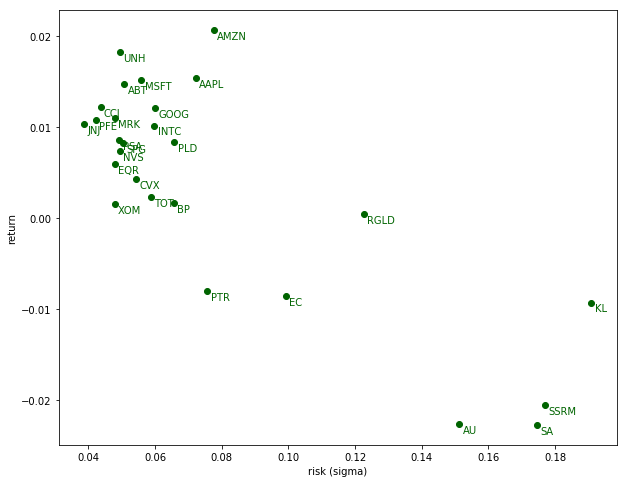

In [191]:
plot_stocks(b)

# (b) Calculate the Sharpe ratio, differential excess return, Treynor measure, and Jensen differential performance index.

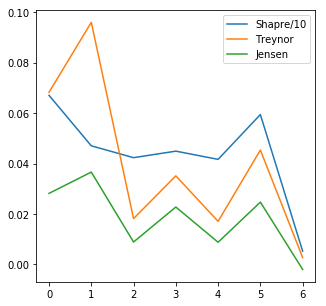

,methods,Shapre/10,Treynor,Jensen
0,Markowitz,0.067069,0.068247,0.028168
1,Single Index Model,0.047036,0.095998,0.036620
2,Single Index Model (No Short Sale),0.042333,0.018174,0.008883
3,Constant Correlation Model,0.044922,0.035124,0.022766
4,Constant Correlation Model (No Short Sale),0.041660,0.017078,0.008787
5,Multiple Group Model,0.059438,0.045356,0.024709
6,Equal Allocation,0.005256,0.002730,-0.001993


In [260]:
xs = [b.x1(),b.x2(),b.x3(),b.x4(),b.x5(),b.x6(),b.x7()]
S, T , J =[] ,[], []
for x in xs:
    S.append( b.Sharpe_ratio(x )/10  )
    T.append( b.Treynor_measure(x)  )
    J.append( b.Jensen_differential_performance_index( x) )
plt.plot(S)
plt.plot(T)
plt.plot(J)
plt.legend(["Shapre/10","Treynor","Jensen"])
plt.show()


methods = ["Markowitz","Single Index Model","Single Index Model (No Short Sale)",\
            "Constant Correlation Model",\
            "Constant Correlation Model (No Short Sale)","Multiple Group Model",\
            "Equal Allocation"]
perfermance = pd.DataFrame({"methods": methods, "Shapre/10":S ,"Treynor":T ,"Jensen":J})

perfermance

# (c) Fama’s decomposition for the single index model with no short sales allowed

In [247]:

betas = b._alpha_beta_sigma2s()[:,1]
beta = np.sum( betas * b.x3() )
sigma2 = np.matmul( np.matmul( b.x3() , b.x2_stocks_covariance() ) , b.x3() )

sigma = np.sqrt(sigma2)
retur = np.sum( b.stocks_return * b.x3() )

betaEffective = sigma / np.sqrt(b.market_variance)

print(beta,retur, sigma , betaEffective)



0.700006060546 0.0147221471762 0.0293880923755 0.882320540098


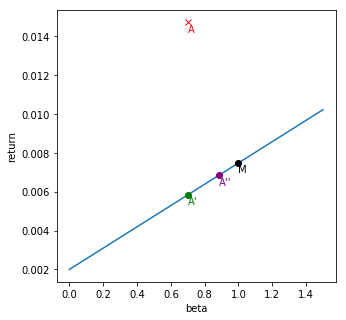

In [278]:
#plt.rcParams['figure.figsize'] = [5, 5]

plt.plot([0,1.5],[b.Rf, (b.market_return-b.Rf)*1.5 + b.Rf ])
plt.plot(1,b.market_return,'o' , color = "black")
plt.annotate(  "M", (1, b.market_return - 0.0005) , color = "black")

plt.plot(beta, (b.market_return-b.Rf)*beta + b.Rf ,'o', color="green")
plt.annotate(  "A'", (beta, (b.market_return-b.Rf)*beta + b.Rf -0.0005 ) , color = "green")


plt.plot(betaEffective, (b.market_return-b.Rf)*betaEffective + b.Rf ,'o', color="purple")
plt.annotate(  "A''", (betaEffective, (b.market_return-b.Rf)*betaEffective + b.Rf -0.0005 ) , color = "purple")

plt.plot(beta, retur, 'x', color = "red")
plt.annotate(  "A", (beta, retur -0.0005  ) , color = "red")

plt.xlabel("beta")
plt.ylabel("return")

plt.show()

![i](https://i.ytimg.com/vi/GKzFOI3kOT0/maxresdefault.jpg)

# (d) VaR for the single index model no short sales allowed

In [261]:

betas = b._alpha_beta_sigma2s()[:,1]
beta = np.sum( betas * b.x3() )
sigma2 = np.matmul( np.matmul( b.x3() , b.x2_stocks_covariance() ) , b.x3() )

sigma = np.sqrt(sigma2)
retur = np.sum( b.stocks_return * b.x3() )

betaEffective = sigma / np.sqrt(b.market_variance)

print(beta,retur, sigma , betaEffective)



0.700006060546 0.0147221471762 0.0293880923755 0.882320540098


### given the return and sigma of that model for a month, let's first convert it to five days

In [262]:
retur5days , sigma5days = retur/6 , sigma/np.sqrt(6)

### Suppose we have $10,000 investment

In [275]:
c =  100000 * ( 1 + np.random.normal(retur5days, sigma5days, 5000) )
c.sort()
print("5 days value at risk 99% = $", 100000 - c[50] )

5 days value at risk 99% = $ 2531.04179129
